# Estimating Economic Growth using Deep Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA

In [2]:
data = pd.read_csv('data.csv')
data

,year,country,gdp,foreign_direct_investment,gross_savings,unemployment,labor_force,mortality_rate,new_businesses_registered,education_expenditure,age_dependency_ratio,food_production_index,human_capital_index,imports,exports,life_expectancy_birth,manufacturing,tobacco_use,profit_tax,population,literacy_rate,birth_rate,death_rate,migration,agriculture_forestry_fishing,industry
0,1996,Afghanistan,NaN,NaN,NaN,NaN,4695426.0,145.6,NaN,NaN,101.779456,90.71,NaN,NaN,NaN,53.924,NaN,NaN,NaN,18853437.0,NaN,48.870,12.964,NaN,NaN,NaN
1,1997,Afghanistan,NaN,NaN,NaN,NaN,4788255.0,141.2,NaN,NaN,102.821757,97.24,NaN,NaN,NaN,54.424,NaN,NaN,NaN,19357126.0,NaN,48.833,12.655,-867540.0,NaN,NaN
2,1998,Afghanistan,NaN,NaN,NaN,NaN,4853675.0,136.9,NaN,NaN,103.650787,103.45,NaN,NaN,NaN,54.906,NaN,NaN,NaN,19737765.0,NaN,48.688,12.348,NaN,NaN,NaN
3,1999,Afghanistan,NaN,NaN,NaN,NaN,4939405.0,132.8,NaN,NaN,104.275819,102.30,NaN,NaN,NaN,55.376,NaN,NaN,NaN,20170844.0,NaN,48.419,12.037,NaN,NaN,NaN
4,2000,Afghanistan,NaN,NaN,NaN,NaN,5071018.0,128.7,NaN,NaN,104.856399,86.04,NaN,NaN,NaN,55.841,NaN,NaN,NaN,20779953.0,NaN,48.021,11.718,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5275,2011,Zimbabwe,1.410192e+10,-344300000.0,-3.479166e+08,5.37,6194591.0,81.4,8541.0,231140838.9,81.230012,88.43,NaN,7.708917e+09,4.907581e+09,52.896,1.293485e+09,NaN,20.0,12894316.0,83.58271,36.526,12.384,NaN,1.222053e+09,3.062978e+09
5276,2012,Zimbabwe,1.711485e+10,-349850000.0,-2.406172e+09,NaN,6285545.0,73.8,9491.0,284614325.8,81.775797,94.08,NaN,8.386153e+09,4.306653e+09,55.032,2.403507e+09,15.2,19.8,13115131.0,NaN,36.292,11.167,-622997.0,1.376807e+09,4.335296e+09
5277,2013,Zimbabwe,1.909102e+10,-373050000.0,-9.432642e+08,NaN,6385796.0,67.8,9782.0,328776408.0,82.350264,92.05,NaN,7.000436e+09,4.197687e+09,56.897,2.466380e+09,NaN,19.6,13350356.0,NaN,35.768,10.115,NaN,1.363954e+09,4.543589e+09
5278,2014,Zimbabwe,1.949552e+10,-472800000.0,-5.911380e+08,4.77,6486791.0,64.4,9465.0,336986734.0,82.840045,91.23,NaN,6.578075e+09,4.080441e+09,58.410,2.454635e+09,14.7,17.7,13586681.0,88.69342,34.978,9.277,NaN,1.704942e+09,4.624054e+09


## Analysing missing data

In [3]:
data.isnull().sum()

year                               0
country                            0
gdp                              316
foreign_direct_investment       1924
gross_savings                   2335
unemployment                    2372
labor_force                      620
mortality_rate                   500
new_businesses_registered       4056
education_expenditure           1635
age_dependency_ratio             484
food_production_index            398
human_capital_index             5177
imports                          768
exports                          772
life_expectancy_birth            361
manufacturing                    954
tobacco_use                     4516
profit_tax                      2851
population                        26
literacy_rate                   3895
birth_rate                       268
death_rate                       279
migration                       4320
agriculture_forestry_fishing     681
industry                         717
dtype: int64

## Calculating GDP per capita

In [4]:
data['gdp_per_capita'] = data.gdp / data.population
data.tail()

,year,country,gdp,foreign_direct_investment,gross_savings,unemployment,labor_force,mortality_rate,new_businesses_registered,education_expenditure,age_dependency_ratio,food_production_index,human_capital_index,imports,exports,life_expectancy_birth,manufacturing,tobacco_use,profit_tax,population,literacy_rate,birth_rate,death_rate,migration,agriculture_forestry_fishing,industry,gdp_per_capita
5275,2011,Zimbabwe,1.410192e+10,-344300000.0,-3.479166e+08,5.37,6194591.0,81.4,8541.0,231140838.9,81.230012,88.43,NaN,7.708917e+09,4.907581e+09,52.896,1.293485e+09,NaN,20.0,12894316.0,83.58271,36.526,12.384,NaN,1.222053e+09,3.062978e+09,1093.654002
5276,2012,Zimbabwe,1.711485e+10,-349850000.0,-2.406172e+09,NaN,6285545.0,73.8,9491.0,284614325.8,81.775797,94.08,NaN,8.386153e+09,4.306653e+09,55.032,2.403507e+09,15.2,19.8,13115131.0,NaN,36.292,11.167,-622997.0,1.376807e+09,4.335296e+09,1304.969802
5277,2013,Zimbabwe,1.909102e+10,-373050000.0,-9.432642e+08,NaN,6385796.0,67.8,9782.0,328776408.0,82.350264,92.05,NaN,7.000436e+09,4.197687e+09,56.897,2.466380e+09,NaN,19.6,13350356.0,NaN,35.768,10.115,NaN,1.363954e+09,4.543589e+09,1430.000818
5278,2014,Zimbabwe,1.949552e+10,-472800000.0,-5.911380e+08,4.77,6486791.0,64.4,9465.0,336986734.0,82.840045,91.23,NaN,6.578075e+09,4.080441e+09,58.410,2.454635e+09,14.7,17.7,13586681.0,88.69342,34.978,9.277,NaN,1.704942e+09,4.624054e+09,1434.899340
5279,2015,Zimbabwe,1.996312e+10,-399200000.0,-1.637758e+09,NaN,6587823.0,62.0,9055.0,343432693.6,83.138588,83.42,NaN,7.503865e+09,3.824969e+09,59.534,2.373335e+09,NaN,17.6,13814629.0,NaN,33.981,8.673,NaN,1.653794e+09,4.463433e+09,1445.071062


## Dropping the data with missing GDP per capita

In [5]:
data.dropna(subset=['gdp_per_capita'], inplace=True)
data.shape

(4964, 27)

In [6]:
data.reset_index(inplace=True)
data.drop('index', axis=1, inplace=True)

## Calculating change in GDP per capita

In [7]:
data_change = data.copy()
data_change['gdp_per_capita2'] = 0
data_change['gdp_per_capita2'][:-1] = data_change['gdp_per_capita'][1:]
data_change['gdp_per_capita_change'] = data_change.gdp_per_capita2 - data_change.gdp_per_capita
data_change.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,year,country,gdp,foreign_direct_investment,gross_savings,unemployment,labor_force,mortality_rate,new_businesses_registered,education_expenditure,age_dependency_ratio,food_production_index,human_capital_index,imports,exports,life_expectancy_birth,manufacturing,tobacco_use,profit_tax,population,literacy_rate,birth_rate,death_rate,migration,agriculture_forestry_fishing,industry,gdp_per_capita,gdp_per_capita2,gdp_per_capita_change
4959,2011,Zimbabwe,1.410192e+10,-344300000.0,-3.479166e+08,5.37,6194591.0,81.4,8541.0,231140838.9,81.230012,88.43,NaN,7.708917e+09,4.907581e+09,52.896,1.293485e+09,NaN,20.0,12894316.0,83.58271,36.526,12.384,NaN,1.222053e+09,3.062978e+09,1093.654002,1304.969802,211.315799
4960,2012,Zimbabwe,1.711485e+10,-349850000.0,-2.406172e+09,NaN,6285545.0,73.8,9491.0,284614325.8,81.775797,94.08,NaN,8.386153e+09,4.306653e+09,55.032,2.403507e+09,15.2,19.8,13115131.0,NaN,36.292,11.167,-622997.0,1.376807e+09,4.335296e+09,1304.969802,1430.000818,125.031016
4961,2013,Zimbabwe,1.909102e+10,-373050000.0,-9.432642e+08,NaN,6385796.0,67.8,9782.0,328776408.0,82.350264,92.05,NaN,7.000436e+09,4.197687e+09,56.897,2.466380e+09,NaN,19.6,13350356.0,NaN,35.768,10.115,NaN,1.363954e+09,4.543589e+09,1430.000818,1434.899340,4.898522
4962,2014,Zimbabwe,1.949552e+10,-472800000.0,-5.911380e+08,4.77,6486791.0,64.4,9465.0,336986734.0,82.840045,91.23,NaN,6.578075e+09,4.080441e+09,58.410,2.454635e+09,14.7,17.7,13586681.0,88.69342,34.978,9.277,NaN,1.704942e+09,4.624054e+09,1434.899340,1445.071062,10.171722
4963,2015,Zimbabwe,1.996312e+10,-399200000.0,-1.637758e+09,NaN,6587823.0,62.0,9055.0,343432693.6,83.138588,83.42,NaN,7.503865e+09,3.824969e+09,59.534,2.373335e+09,NaN,17.6,13814629.0,NaN,33.981,8.673,NaN,1.653794e+09,4.463433e+09,1445.071062,0.000000,-1445.071062


In [8]:
data_change.iloc[:-1, 1:-3] = data_change.iloc[1:, 1:-3]
data_change.tail()

,year,country,gdp,foreign_direct_investment,gross_savings,unemployment,labor_force,mortality_rate,new_businesses_registered,education_expenditure,age_dependency_ratio,food_production_index,human_capital_index,imports,exports,life_expectancy_birth,manufacturing,tobacco_use,profit_tax,population,literacy_rate,birth_rate,death_rate,migration,agriculture_forestry_fishing,industry,gdp_per_capita,gdp_per_capita2,gdp_per_capita_change
4959,2011,Zimbabwe,1.410192e+10,-344300000.0,-3.479166e+08,5.37,6194591.0,81.4,8541.0,231140838.9,81.230012,88.43,NaN,7.708917e+09,4.907581e+09,52.896,1.293485e+09,NaN,20.0,12894316.0,83.58271,36.526,12.384,NaN,1.222053e+09,3.062978e+09,1093.654002,1304.969802,211.315799
4960,2012,Zimbabwe,1.711485e+10,-349850000.0,-2.406172e+09,NaN,6285545.0,73.8,9491.0,284614325.8,81.775797,94.08,NaN,8.386153e+09,4.306653e+09,55.032,2.403507e+09,15.2,19.8,13115131.0,NaN,36.292,11.167,-622997.0,1.376807e+09,4.335296e+09,1304.969802,1430.000818,125.031016
4961,2013,Zimbabwe,1.909102e+10,-373050000.0,-9.432642e+08,NaN,6385796.0,67.8,9782.0,328776408.0,82.350264,92.05,NaN,7.000436e+09,4.197687e+09,56.897,2.466380e+09,NaN,19.6,13350356.0,NaN,35.768,10.115,NaN,1.363954e+09,4.543589e+09,1430.000818,1434.899340,4.898522
4962,2014,Zimbabwe,1.949552e+10,-472800000.0,-5.911380e+08,4.77,6486791.0,64.4,9465.0,336986734.0,82.840045,91.23,NaN,6.578075e+09,4.080441e+09,58.410,2.454635e+09,14.7,17.7,13586681.0,88.69342,34.978,9.277,NaN,1.704942e+09,4.624054e+09,1434.899340,1445.071062,10.171722
4963,2015,Zimbabwe,1.996312e+10,-399200000.0,-1.637758e+09,NaN,6587823.0,62.0,9055.0,343432693.6,83.138588,83.42,NaN,7.503865e+09,3.824969e+09,59.534,2.373335e+09,NaN,17.6,13814629.0,NaN,33.981,8.673,NaN,1.653794e+09,4.463433e+09,1445.071062,0.000000,-1445.071062


In [9]:
data_change.set_index('year', inplace=True)
data_change.drop(2015, inplace=True)
data_change.reset_index(inplace=True)
data_change.year = data_change.year + 1
data_change

,year,country,gdp,foreign_direct_investment,gross_savings,unemployment,labor_force,mortality_rate,new_businesses_registered,education_expenditure,age_dependency_ratio,food_production_index,human_capital_index,imports,exports,life_expectancy_birth,manufacturing,tobacco_use,profit_tax,population,literacy_rate,birth_rate,death_rate,migration,agriculture_forestry_fishing,industry,gdp_per_capita,gdp_per_capita2,gdp_per_capita_change
0,2003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,179.426611,190.683814,11.257203
1,2004,Afghanistan,4.515559e+09,NaN,NaN,NaN,5886907.0,116.3,NaN,NaN,102.663238,98.77,NaN,NaN,NaN,57.271,7.642071e+08,NaN,NaN,23680871.0,NaN,46.231,10.704,NaN,1.689670e+09,1.025522e+09,190.683814,211.382117,20.698303
2,2005,Afghanistan,5.226779e+09,NaN,NaN,NaN,6198355.0,112.1,NaN,NaN,101.562371,96.05,NaN,NaN,NaN,57.772,9.175091e+08,NaN,NaN,24726684.0,NaN,45.507,10.356,NaN,1.553454e+09,1.370816e+09,211.382117,242.031285,30.649168
3,2006,Afghanistan,6.209138e+09,NaN,NaN,NaN,6483460.0,107.9,NaN,NaN,100.349127,106.32,NaN,NaN,NaN,58.290,1.030606e+09,NaN,0.0,25654277.0,NaN,44.723,10.003,NaN,1.931964e+09,1.664800e+09,242.031285,263.733692,21.702407
4,2007,Afghanistan,6.971286e+09,NaN,NaN,NaN,6644359.0,103.7,NaN,NaN,100.970943,97.63,NaN,NaN,NaN,58.826,1.142283e+09,NaN,0.0,26433049.0,NaN,43.870,9.645,NaN,1.996295e+09,1.966653e+09,263.733692,359.693238,95.959546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4707,2011,Zimbabwe,1.204166e+10,-122586666.7,-5.406888e+08,NaN,6110063.0,87.6,5024.0,202733869.2,80.772069,91.92,0.410366,6.440274e+09,3.569254e+09,50.640,1.108809e+09,15.6,23.6,12697723.0,NaN,36.464,13.679,NaN,1.157187e+09,2.491866e+09,948.331854,1093.654002,145.322148
4708,2012,Zimbabwe,1.410192e+10,-344300000.0,-3.479166e+08,5.37,6194591.0,81.4,8541.0,231140838.9,81.230012,88.43,NaN,7.708917e+09,4.907581e+09,52.896,1.293485e+09,NaN,20.0,12894316.0,83.58271,36.526,12.384,NaN,1.222053e+09,3.062978e+09,1093.654002,1304.969802,211.315799
4709,2013,Zimbabwe,1.711485e+10,-349850000.0,-2.406172e+09,NaN,6285545.0,73.8,9491.0,284614325.8,81.775797,94.08,NaN,8.386153e+09,4.306653e+09,55.032,2.403507e+09,15.2,19.8,13115131.0,NaN,36.292,11.167,-622997.0,1.376807e+09,4.335296e+09,1304.969802,1430.000818,125.031016
4710,2014,Zimbabwe,1.909102e+10,-373050000.0,-9.432642e+08,NaN,6385796.0,67.8,9782.0,328776408.0,82.350264,92.05,NaN,7.000436e+09,4.197687e+09,56.897,2.466380e+09,NaN,19.6,13350356.0,NaN,35.768,10.115,NaN,1.363954e+09,4.543589e+09,1430.000818,1434.899340,4.898522


In [10]:
data.drop(['year', 'country', 'gdp'], axis=1, inplace=True)
data_change.drop(['year', 'country', 'gdp', 'gdp_per_capita', 'gdp_per_capita2'], axis=1, inplace=True)

## Plot of the target variable

Mean: 11962.181575678831
Standard Deviation: 19654.17102853881
Mean Absolute Deviation: 12953.537672132428


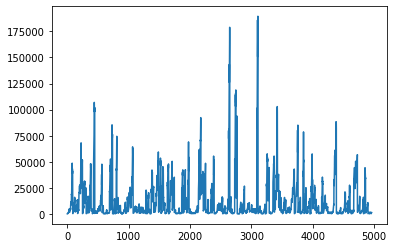

In [11]:
data.gdp_per_capita.plot()
print('Mean:', data.gdp_per_capita.mean())
print('Standard Deviation:', data.gdp_per_capita.std())
print('Mean Absolute Deviation:', data.gdp_per_capita.mad())

Mean: 388.5126814553981
Standard Deviation: 2625.5343966471155
Mean Absolute Deviation: 1101.8053430571554


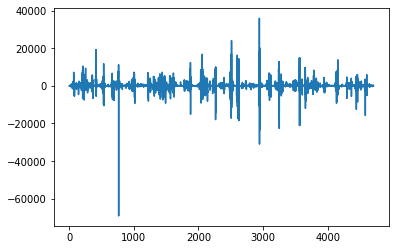

In [12]:
data_change.gdp_per_capita_change.plot()
print('Mean:', data_change.gdp_per_capita_change.mean())
print('Standard Deviation:', data_change.gdp_per_capita_change.std())
print('Mean Absolute Deviation:', data_change.gdp_per_capita_change.mad())

## Imputing the NaN values using k-Nearest Neighbors

In [13]:
columns = data.columns
imp = KNNImputer(n_neighbors=20)
data = pd.DataFrame(imp.fit_transform(data), columns=columns)
data.head()

,foreign_direct_investment,gross_savings,unemployment,labor_force,mortality_rate,new_businesses_registered,education_expenditure,age_dependency_ratio,food_production_index,human_capital_index,imports,exports,life_expectancy_birth,manufacturing,tobacco_use,profit_tax,population,literacy_rate,birth_rate,death_rate,migration,agriculture_forestry_fishing,industry,gdp_per_capita
0,4.009594e+08,1.214872e+10,12.9595,5573458.0,120.4,1734.65,3.828470e+09,103.671183,95.55,0.462984,6.217705e+10,6.630443e+10,56.784,7.632964e+08,30.199152,13.47,22600770.0,83.951326,46.901,11.048,744193.0,1.566430e+09,9.655434e+08,179.426611
1,4.275146e+08,1.232639e+10,11.1695,5886907.0,116.3,1974.90,3.829041e+09,102.663238,98.77,0.462984,6.244168e+10,6.655635e+10,57.271,7.642071e+08,31.034953,13.47,23680871.0,84.081225,46.231,10.704,-26895.5,1.689670e+09,1.025522e+09,190.683814
2,4.275146e+08,1.232639e+10,11.1695,6198355.0,112.1,1786.90,3.829041e+09,101.562371,96.05,0.471168,6.244168e+10,6.655635e+10,57.772,9.175091e+08,30.394176,13.47,24726684.0,72.786418,45.507,10.356,-26895.5,1.553454e+09,1.370816e+09,211.382117
3,3.725631e+08,1.205180e+10,11.1695,6483460.0,107.9,2329.25,3.829041e+09,100.349127,106.32,0.471168,6.161883e+10,6.555092e+10,58.290,1.030606e+09,28.520000,0.00,25654277.0,73.454779,44.723,10.003,-30853.5,1.931964e+09,1.664800e+09,242.031285
4,3.725631e+08,1.205180e+10,11.1695,6644359.0,103.7,1500.50,3.829041e+09,100.970943,97.63,0.489346,6.161883e+10,6.555092e+10,58.826,1.142283e+09,28.280000,0.00,26433049.0,67.731697,43.870,9.645,-30853.5,1.996295e+09,1.966653e+09,263.733692


In [14]:
columns_change = data_change.columns
imp_change = KNNImputer(n_neighbors=20)
data_change = pd.DataFrame(imp_change.fit_transform(data_change), columns=columns_change)
data_change.head()

,foreign_direct_investment,gross_savings,unemployment,labor_force,mortality_rate,new_businesses_registered,education_expenditure,age_dependency_ratio,food_production_index,human_capital_index,imports,exports,life_expectancy_birth,manufacturing,tobacco_use,profit_tax,population,literacy_rate,birth_rate,death_rate,migration,agriculture_forestry_fishing,industry,gdp_per_capita_change
0,3.088119e+09,1.237779e+09,6.96869,4.560524e+08,112.766206,39972.80,9.477272e+10,79.847029,98.177281,0.650346,6.914586e+10,1.931513e+11,63.444154,2.136568e+12,21.843656,17.595487,2.035630e+09,73.992813,22.090144,9.35803,-7621793.25,5.921440e+11,3.794154e+12,11.257203
1,4.016679e+08,1.232639e+10,11.28800,5.886907e+06,116.300000,1974.90,3.799024e+09,102.663238,98.770000,0.462984,6.174073e+10,6.639947e+10,57.271000,7.642071e+08,31.034953,13.250000,2.368087e+07,84.168586,46.231000,10.70400,-26895.50,1.689670e+09,1.025522e+09,20.698303
2,4.016679e+08,1.232639e+10,11.28800,6.198355e+06,112.100000,1786.90,3.799024e+09,101.562371,96.050000,0.471168,6.174073e+10,6.639947e+10,57.772000,9.175091e+08,30.394176,13.250000,2.472668e+07,72.746348,45.507000,10.35600,-26895.50,1.553454e+09,1.370816e+09,30.649168
3,3.071568e+08,1.204444e+10,11.28800,6.483460e+06,107.900000,2354.30,3.799772e+09,100.349127,106.320000,0.471168,6.084707e+10,6.535828e+10,58.290000,1.030606e+09,28.520000,0.000000,2.565428e+07,73.454779,44.723000,10.00300,-30853.50,1.931964e+09,1.664800e+09,21.702407
4,3.071568e+08,1.204444e+10,11.28800,6.644359e+06,103.700000,1442.95,3.799772e+09,100.970943,97.630000,0.489346,6.084707e+10,6.535828e+10,58.826000,1.142283e+09,28.280000,0.000000,2.643305e+07,67.731697,43.870000,9.64500,-30853.50,1.996295e+09,1.966653e+09,95.959546


## Data Visualization

#### Scatter plot between different input variables and target variable:

gdp_per_capita vs input variables


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


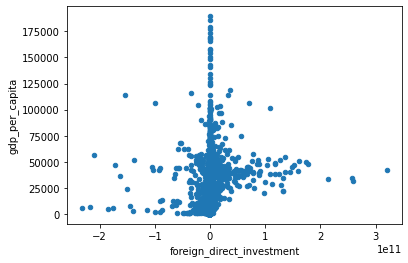

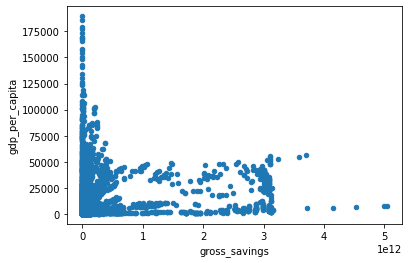

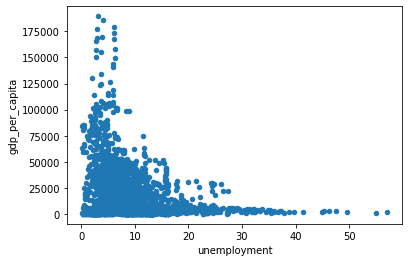

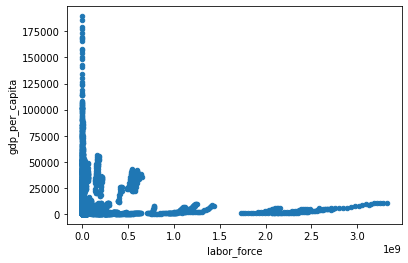

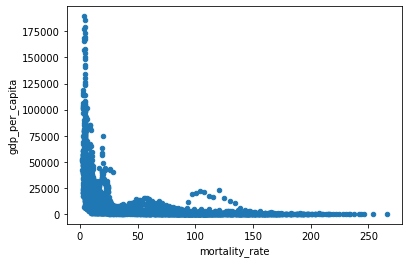

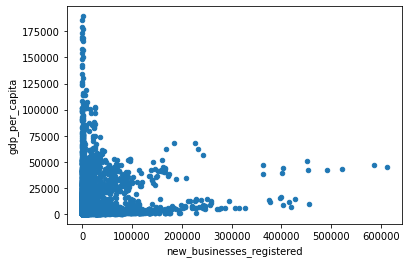

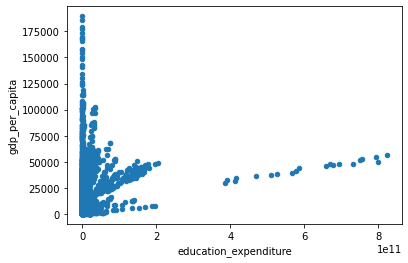

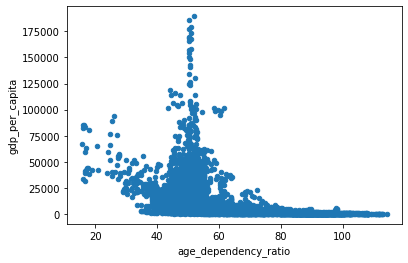

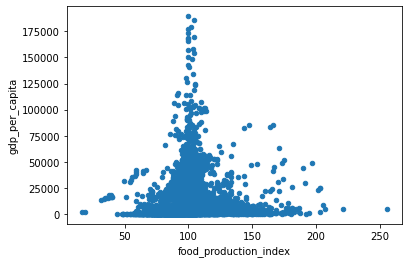

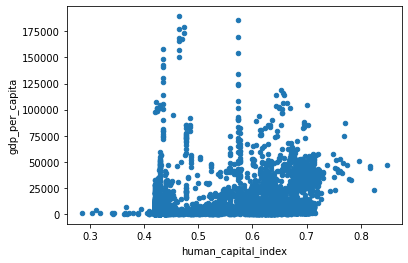

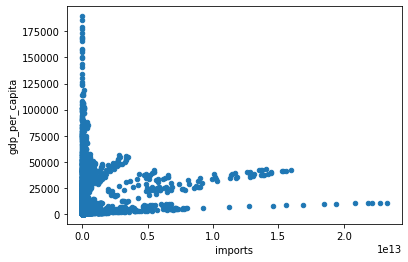

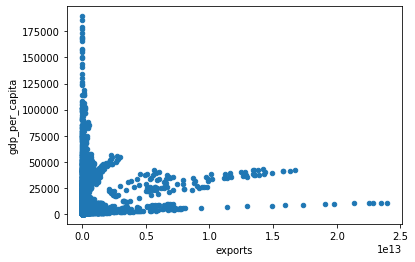

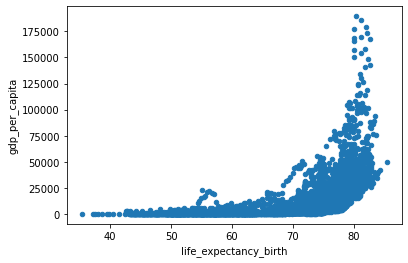

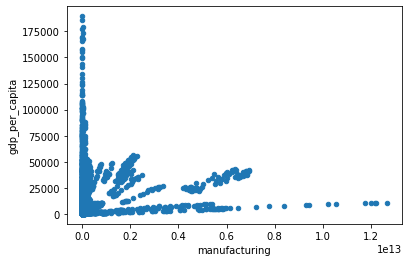

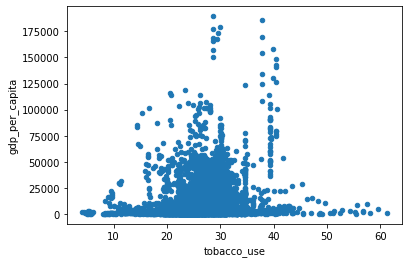

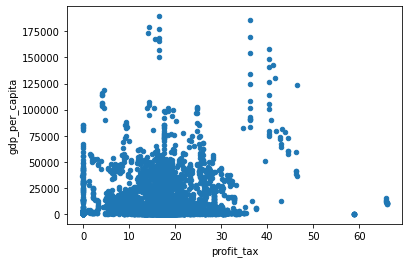

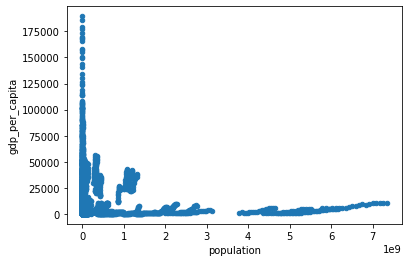

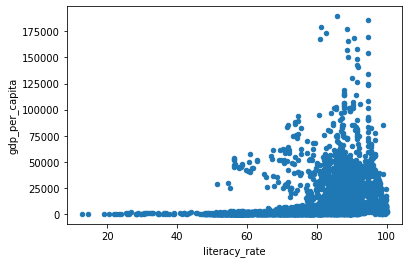

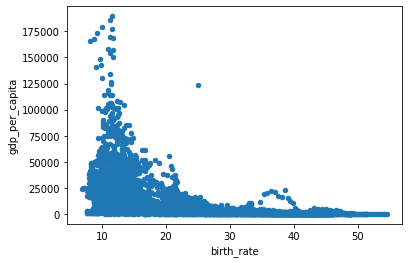

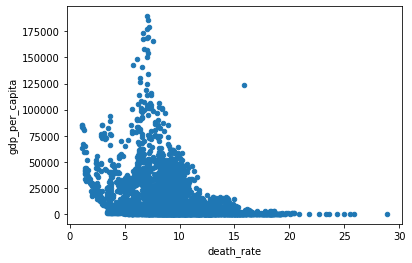

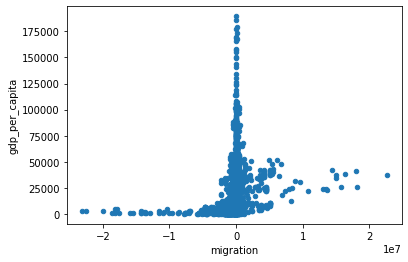

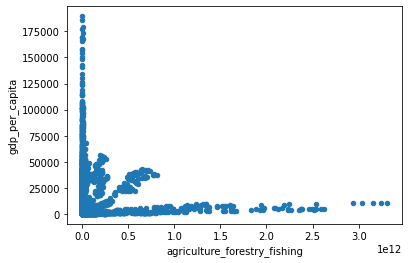

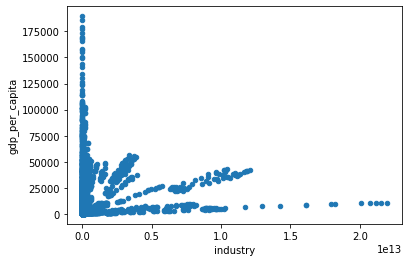

In [15]:
columns = data.columns
a = data.shape[1]
print("gdp_per_capita vs input variables")
for i in range(a-1):
  
  data.plot.scatter(x=columns[i],
                      y=columns[-1])

#### Box plot illustrating distribution of all input variables together with target variable in same plot:

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24]),
 <a list of 24 Text major ticklabel objects>)

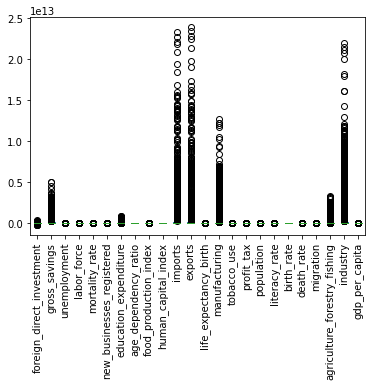

In [16]:
columns = data.columns
data[columns].plot.box()
plt.xticks(rotation='vertical')

#### Performing PCA on Data to reduce dimension to 3 to better visualize the data 

In [17]:
# np.random.seed(42)
# rndperm = np.random.permutation(data.shape[0])

In [18]:
# pca = PCA(n_components=3)
# pca_result = pca.fit_transform(data[columns].values)
# data['pca-one'] = pca_result[:,0]
# data['pca-two'] = pca_result[:,1] 
# data['pca-three'] = pca_result[:,2]
# print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

In [19]:
# data['y'] = data.index

In [20]:
# data.shape

In [21]:
# ax = plt.figure(figsize=(16,10)).gca(projection='3d')
# ax.scatter(
#     xs=data.loc[rndperm,:]["pca-one"], 
#     ys=data.loc[rndperm,:]["pca-two"], 
#     zs=data.loc[rndperm,:]["pca-three"], 
#     c=data.loc[rndperm,:]["y"], 
#     cmap='tab10'
# )
# ax.set_xlabel('pca-one')
# ax.set_ylabel('pca-two')
# ax.set_zlabel('pca-three')
# plt.show()

## Correlation heatmap between the variables

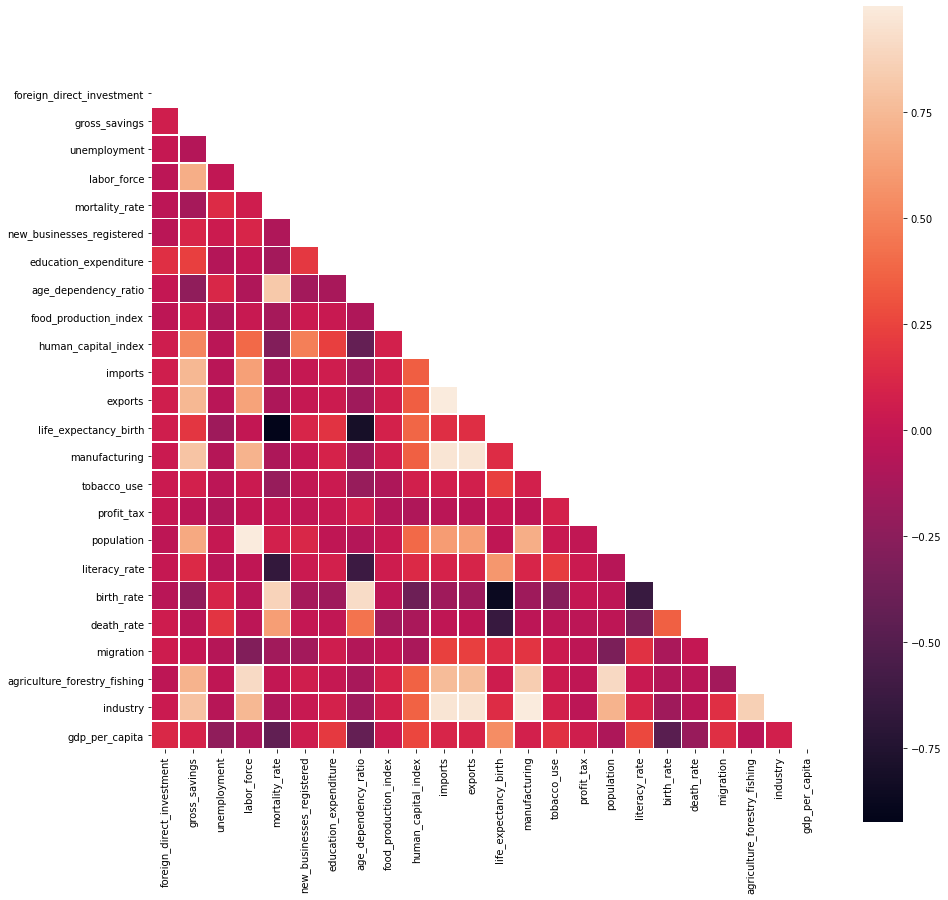

In [22]:
plt.figure(figsize=(15, 15))
matrix = np.triu(data.corr())
sns.heatmap(data.corr(), mask=matrix, square=True, linewidths=0.5)

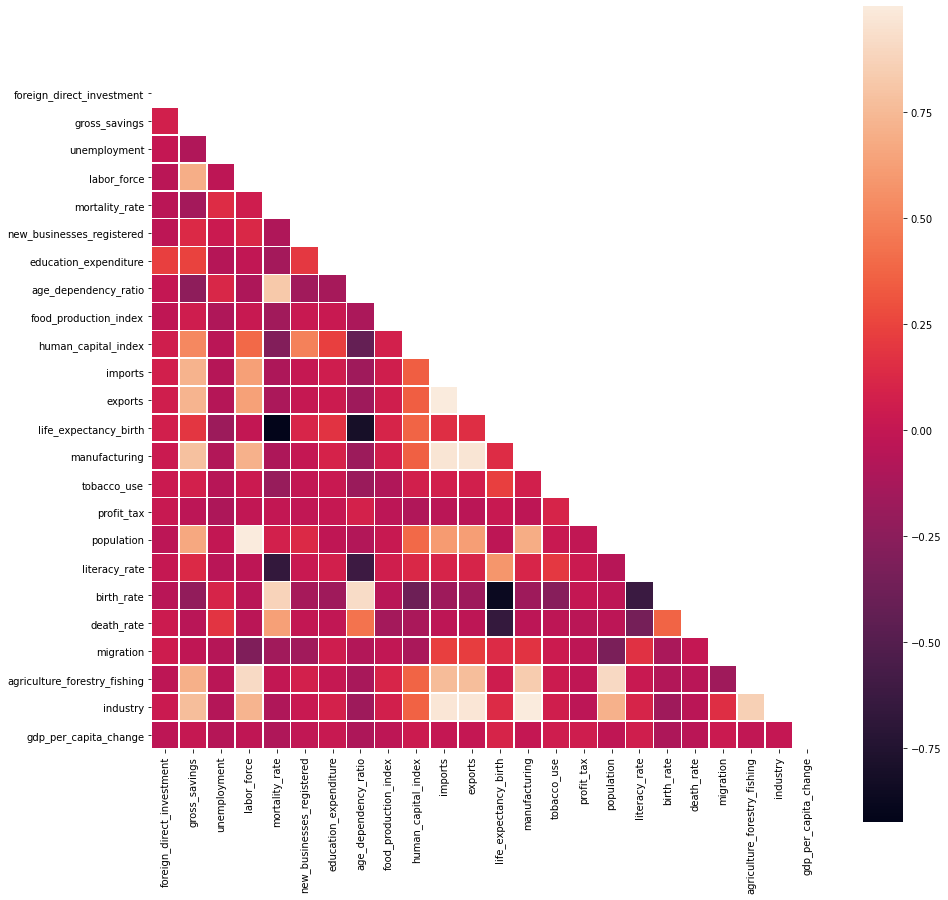

In [23]:
plt.figure(figsize=(15, 15))
matrix = np.triu(data_change.corr())
sns.heatmap(data_change.corr(), mask=matrix, square=True, linewidths=0.5)

## Saving the data to a CSV file

In [24]:
data.to_csv('data_final.csv', index=False)
data_change.to_csv('data_change_final.csv', index=False)